In [23]:
# Convolution GAN Alec Radford 2016

# 1. Strided convolutional layers
# 2. Batch Normalization mean=0 and variance=1
        # mitigates vanishing gradients
        # aids in alleviating mode collapse
# 3. No fully connected hidden layers

In [24]:
! pip install tensorflow tqdm

In [25]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [26]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [27]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

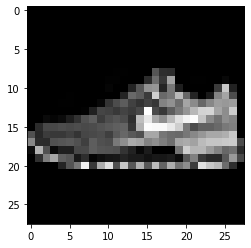

In [28]:
train_images = (train_images - 127.5) / 127.5
plt.imshow(train_images[2567].squeeze(), cmap="gray")

In [29]:
buffer_size: int = 60000
batch_size: int = 32

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [31]:
from multiprocessing.dummy import active_children


def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2, 2), padding="same", activation="tanh"))
    
    return model

generator = generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_5 (Batch (None, 12544)             50176     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 7, 7, 128)        

In [32]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image.shape

TensorShape([1, 28, 28, 1])

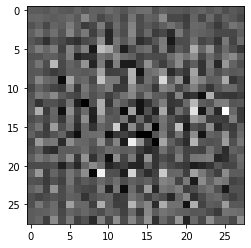

In [33]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [34]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding="same", input_shape =[28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [35]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.4999265]], shape=(1, 1), dtype=float32)


In [36]:
bce = tf.keras.losses.BinaryCrossentropy()

In [37]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [38]:
generator_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [39]:
# checkpoint_dir = "data-cnn-gan/gray/training_checkpoints"
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(generator_optimizer = generator_opt,
#                                  discriminator_optimizer = discriminator_opt,
#                                  generator=generator,
#                                  discriminator=discriminator
#                                  )

In [40]:
from numpy import number


epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [41]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
    
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [42]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap="gray")
        plt.axis('off')
    
#     plt.savefig('data-cnn-gan/gray/images/image_at_epoch {:04d}.png'.format(epoch))
    plt.show()

In [43]:
from sklearn.model_selection import train_test_split


def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        
        num_batches = len(dataset)
        
        print(f"Training started with epoch {epoch+1} with {num_batches} batches...")
        
        total_gen_loss, total_disc_loss = 0, 0
        
        for batch in dataset:
            gen_loss, disc_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
        
        print(f"Epoch: {epoch+1}: Generator loss: {gen_loss: 3f}, Discriminator loss: {disc_loss: 3f}, Real Score: {real_score: 3f}. Fake Score: {fake_score: 3f}")
        
        generate_and_plot_images(generator, epoch+1, seed)
        
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)
        
        if (epoch+1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch: {epoch+1} is {time.time() - start} seconds")
        
    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list
        

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 1875 batches...
Epoch: 1: Generator loss:  2.863497, Discriminator loss:  0.722899, Real Score:  0.878217. Fake Score:  0.260958


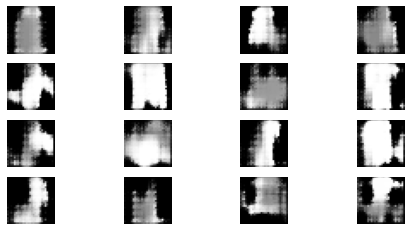

  2%|▏         | 1/50 [00:16<13:10, 16.13s/it]

Time for epoch: 1 is 16.127397537231445 seconds
Training started with epoch 2 with 1875 batches...
Epoch: 2: Generator loss:  1.638569, Discriminator loss:  1.257004, Real Score:  0.844672. Fake Score:  0.393636


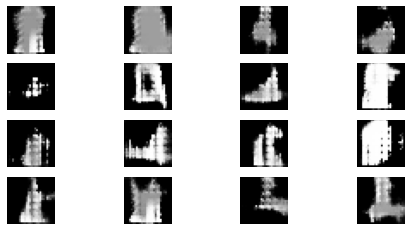

  4%|▍         | 2/50 [00:30<12:06, 15.14s/it]

Time for epoch: 2 is 14.445086240768433 seconds
Training started with epoch 3 with 1875 batches...
Epoch: 3: Generator loss:  4.115702, Discriminator loss:  0.578730, Real Score:  0.749761. Fake Score:  0.074628


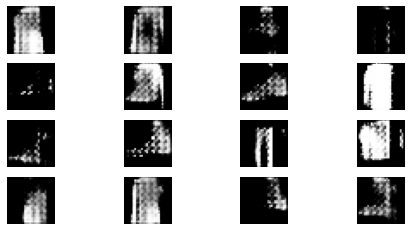

  6%|▌         | 3/50 [00:45<11:43, 14.96s/it]

Time for epoch: 3 is 14.744208812713623 seconds
Training started with epoch 4 with 1875 batches...
Epoch: 4: Generator loss:  2.399793, Discriminator loss:  0.552685, Real Score:  0.884146. Fake Score:  0.210498


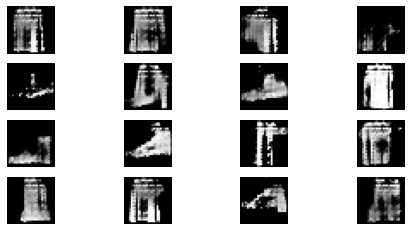

  8%|▊         | 4/50 [01:00<11:24, 14.88s/it]

Time for epoch: 4 is 14.746922731399536 seconds
Training started with epoch 5 with 1875 batches...
Epoch: 5: Generator loss:  3.458030, Discriminator loss:  0.568953, Real Score:  0.726373. Fake Score:  0.073035


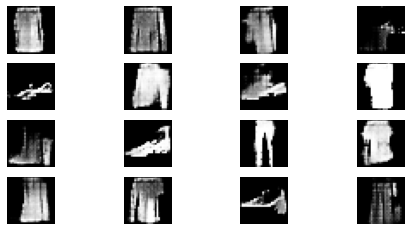

 10%|█         | 5/50 [01:14<11:05, 14.79s/it]

Time for epoch: 5 is 14.626428842544556 seconds
Training started with epoch 6 with 1875 batches...
Epoch: 6: Generator loss:  2.046193, Discriminator loss:  0.953361, Real Score:  0.686921. Fake Score:  0.284630


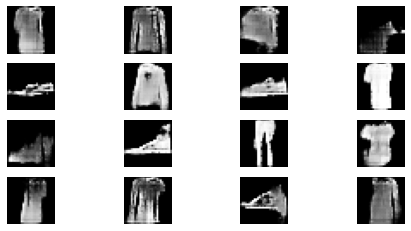

 12%|█▏        | 6/50 [01:29<10:56, 14.92s/it]

Time for epoch: 6 is 15.178508520126343 seconds
Training started with epoch 7 with 1875 batches...
Epoch: 7: Generator loss:  1.768208, Discriminator loss:  1.475813, Real Score:  0.497681. Fake Score:  0.285815


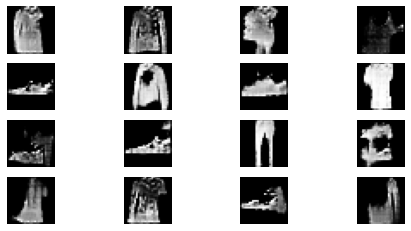

 14%|█▍        | 7/50 [01:45<10:45, 15.00s/it]

Time for epoch: 7 is 15.165884256362915 seconds
Training started with epoch 8 with 1875 batches...
Epoch: 8: Generator loss:  1.641998, Discriminator loss:  0.840490, Real Score:  0.791951. Fake Score:  0.336734


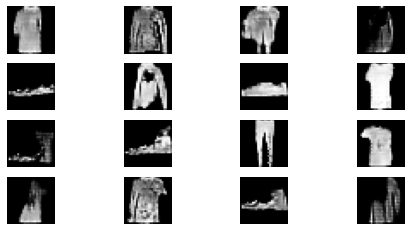

 16%|█▌        | 8/50 [02:00<10:30, 15.01s/it]

Time for epoch: 8 is 15.035748720169067 seconds
Training started with epoch 9 with 1875 batches...
Epoch: 9: Generator loss:  2.064284, Discriminator loss:  0.818158, Real Score:  0.687253. Fake Score:  0.244221


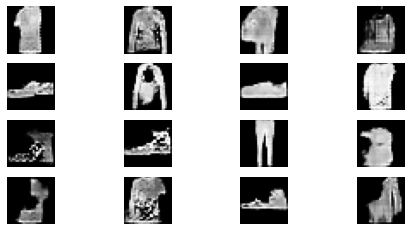

 18%|█▊        | 9/50 [02:14<10:13, 14.97s/it]

Time for epoch: 9 is 14.874766826629639 seconds
Training started with epoch 10 with 1875 batches...
Epoch: 10: Generator loss:  1.429259, Discriminator loss:  1.209605, Real Score:  0.570907. Fake Score:  0.305037


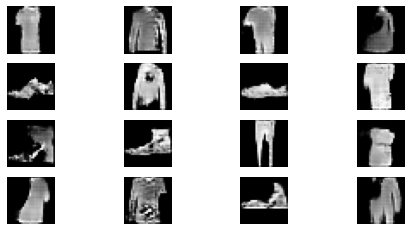

 20%|██        | 10/50 [02:29<09:59, 14.99s/it]

Time for epoch: 10 is 15.03865098953247 seconds
Training started with epoch 11 with 1875 batches...
Epoch: 11: Generator loss:  1.365941, Discriminator loss:  1.161663, Real Score:  0.586125. Fake Score:  0.337440


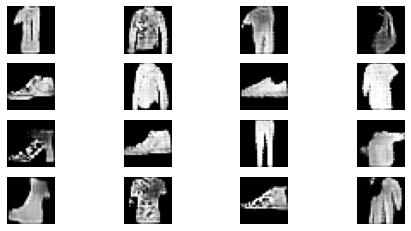

 22%|██▏       | 11/50 [02:45<09:45, 15.02s/it]

Time for epoch: 11 is 15.081719398498535 seconds
Training started with epoch 12 with 1875 batches...
Epoch: 12: Generator loss:  1.041696, Discriminator loss:  1.425105, Real Score:  0.556852. Fake Score:  0.417454


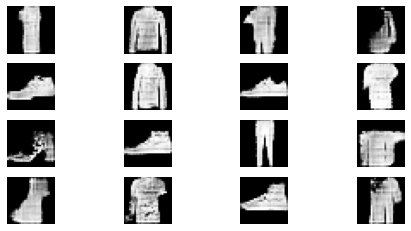

 24%|██▍       | 12/50 [03:00<09:31, 15.04s/it]

Time for epoch: 12 is 15.083773374557495 seconds
Training started with epoch 13 with 1875 batches...
Epoch: 13: Generator loss:  0.980685, Discriminator loss:  0.894649, Real Score:  0.838558. Fake Score:  0.443286


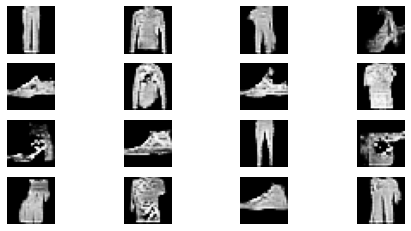

 26%|██▌       | 13/50 [03:14<09:13, 14.96s/it]

Time for epoch: 13 is 14.786484003067017 seconds
Training started with epoch 14 with 1875 batches...
Epoch: 14: Generator loss:  0.946140, Discriminator loss:  1.171111, Real Score:  0.758406. Fake Score:  0.477547


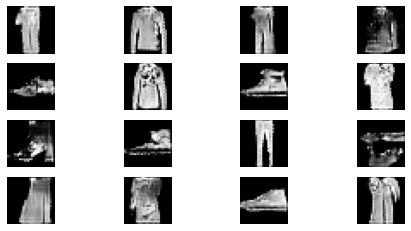

 28%|██▊       | 14/50 [03:30<09:03, 15.09s/it]

Time for epoch: 14 is 15.382112264633179 seconds
Training started with epoch 15 with 1875 batches...
Epoch: 15: Generator loss:  1.651472, Discriminator loss:  1.250995, Real Score:  0.582047. Fake Score:  0.341353


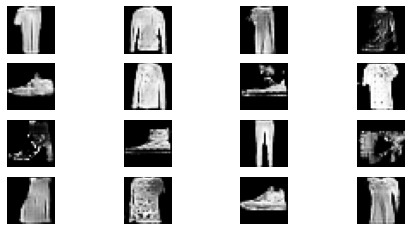

 30%|███       | 15/50 [03:45<08:50, 15.16s/it]

Time for epoch: 15 is 15.33266544342041 seconds
Training started with epoch 16 with 1875 batches...
Epoch: 16: Generator loss:  1.676492, Discriminator loss:  0.853855, Real Score:  0.686146. Fake Score:  0.272619


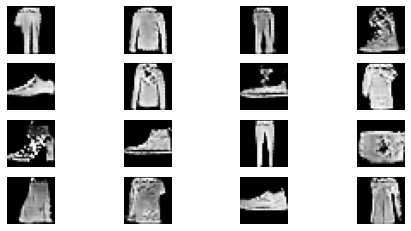

 32%|███▏      | 16/50 [04:00<08:31, 15.04s/it]

Time for epoch: 16 is 14.74456787109375 seconds
Training started with epoch 17 with 1875 batches...
Epoch: 17: Generator loss:  1.006625, Discriminator loss:  1.541238, Real Score:  0.472051. Fake Score:  0.410669


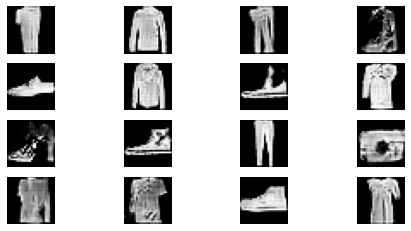

 34%|███▍      | 17/50 [04:15<08:16, 15.05s/it]

Time for epoch: 17 is 15.073935747146606 seconds
Training started with epoch 18 with 1875 batches...
Epoch: 18: Generator loss:  1.711087, Discriminator loss:  1.336676, Real Score:  0.484616. Fake Score:  0.295612


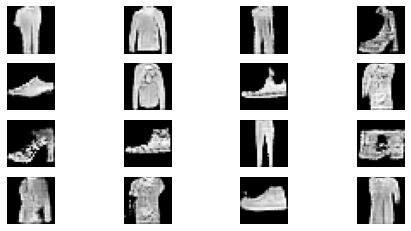

 36%|███▌      | 18/50 [04:30<08:01, 15.04s/it]

Time for epoch: 18 is 15.024533987045288 seconds
Training started with epoch 19 with 1875 batches...
Epoch: 19: Generator loss:  1.068533, Discriminator loss:  1.467022, Real Score:  0.588713. Fake Score:  0.429579


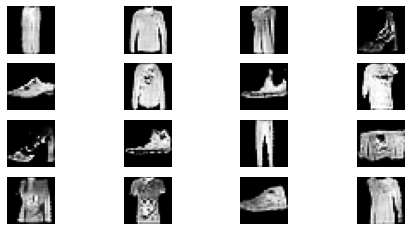

 38%|███▊      | 19/50 [04:45<07:45, 15.02s/it]

Time for epoch: 19 is 14.970057725906372 seconds
Training started with epoch 20 with 1875 batches...
Epoch: 20: Generator loss:  1.364066, Discriminator loss:  0.923264, Real Score:  0.702431. Fake Score:  0.340691


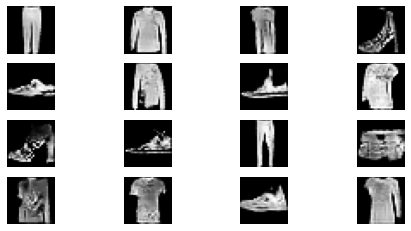

 40%|████      | 20/50 [05:00<07:30, 15.02s/it]

Time for epoch: 20 is 15.008922100067139 seconds
Training started with epoch 21 with 1875 batches...
Epoch: 21: Generator loss:  1.092294, Discriminator loss:  1.180663, Real Score:  0.577374. Fake Score:  0.384917


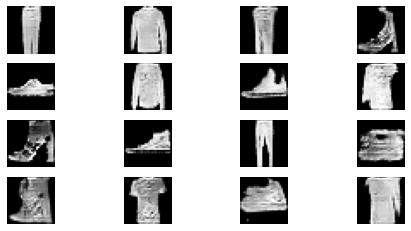

 42%|████▏     | 21/50 [05:15<07:15, 15.01s/it]

Time for epoch: 21 is 15.000322818756104 seconds
Training started with epoch 22 with 1875 batches...
Epoch: 22: Generator loss:  0.840405, Discriminator loss:  1.208824, Real Score:  0.744861. Fake Score:  0.495282


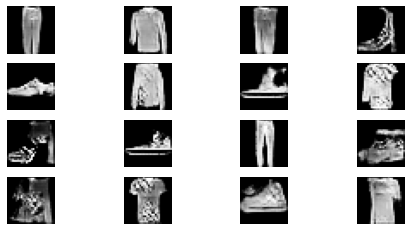

 44%|████▍     | 22/50 [05:30<07:00, 15.03s/it]

Time for epoch: 22 is 15.065881490707397 seconds
Training started with epoch 23 with 1875 batches...
Epoch: 23: Generator loss:  1.715971, Discriminator loss:  1.127546, Real Score:  0.562313. Fake Score:  0.266046


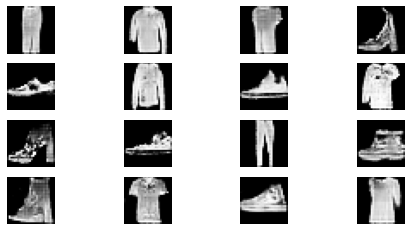

 46%|████▌     | 23/50 [05:45<06:45, 15.02s/it]

Time for epoch: 23 is 15.010794401168823 seconds
Training started with epoch 24 with 1875 batches...
Epoch: 24: Generator loss:  0.853115, Discriminator loss:  1.186478, Real Score:  0.762055. Fake Score:  0.499377


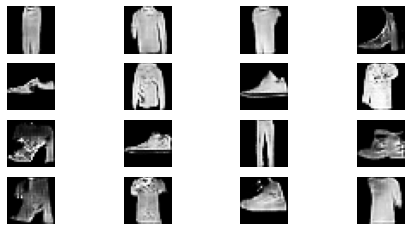

 48%|████▊     | 24/50 [06:00<06:28, 14.94s/it]

Time for epoch: 24 is 14.750749349594116 seconds
Training started with epoch 25 with 1875 batches...
Epoch: 25: Generator loss:  0.993811, Discriminator loss:  1.150531, Real Score:  0.619337. Fake Score:  0.410365


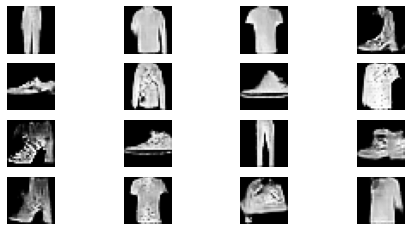

 50%|█████     | 25/50 [06:15<06:15, 15.02s/it]

Time for epoch: 25 is 15.207224607467651 seconds
Training started with epoch 26 with 1875 batches...
Epoch: 26: Generator loss:  0.797410, Discriminator loss:  1.632140, Real Score:  0.540246. Fake Score:  0.534124


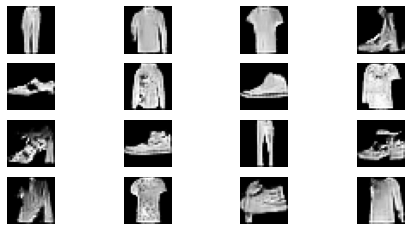

 52%|█████▏    | 26/50 [06:30<06:00, 15.04s/it]

Time for epoch: 26 is 15.072004318237305 seconds
Training started with epoch 27 with 1875 batches...
Epoch: 27: Generator loss:  1.038616, Discriminator loss:  1.112421, Real Score:  0.645278. Fake Score:  0.414124


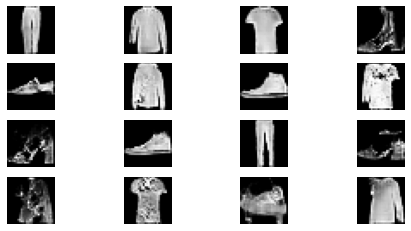

 54%|█████▍    | 27/50 [06:45<05:45, 15.00s/it]

Time for epoch: 27 is 14.914811134338379 seconds
Training started with epoch 28 with 1875 batches...
Epoch: 28: Generator loss:  1.344367, Discriminator loss:  1.168612, Real Score:  0.660740. Fake Score:  0.396798


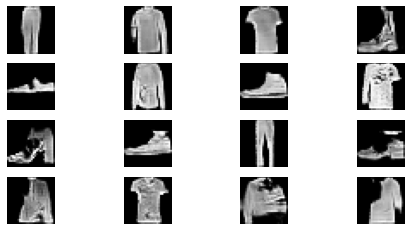

 56%|█████▌    | 28/50 [07:00<05:29, 14.98s/it]

Time for epoch: 28 is 14.913126707077026 seconds
Training started with epoch 29 with 1875 batches...
Epoch: 29: Generator loss:  1.145981, Discriminator loss:  0.996164, Real Score:  0.693823. Fake Score:  0.395837


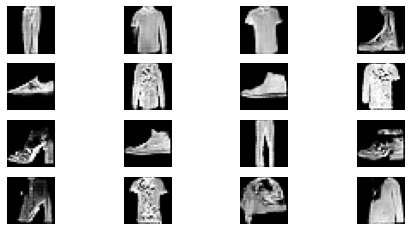

 58%|█████▊    | 29/50 [07:15<05:17, 15.12s/it]

Time for epoch: 29 is 15.463591575622559 seconds
Training started with epoch 30 with 1875 batches...
Epoch: 30: Generator loss:  0.998855, Discriminator loss:  1.266296, Real Score:  0.582880. Fake Score:  0.428461


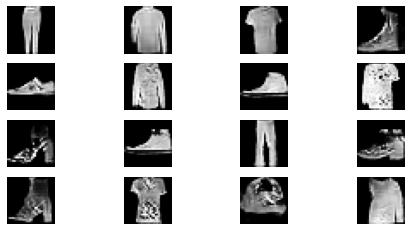

 60%|██████    | 30/50 [07:30<05:00, 15.04s/it]

Time for epoch: 30 is 14.847237348556519 seconds
Training started with epoch 31 with 1875 batches...
Epoch: 31: Generator loss:  0.821276, Discriminator loss:  1.487006, Real Score:  0.503563. Fake Score:  0.475123


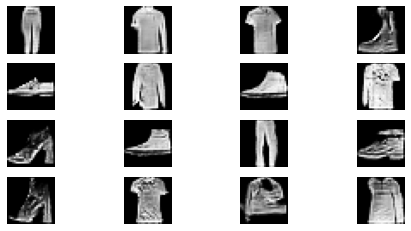

 62%|██████▏   | 31/50 [07:45<04:45, 15.03s/it]

Time for epoch: 31 is 15.01284670829773 seconds
Training started with epoch 32 with 1875 batches...
Epoch: 32: Generator loss:  1.038597, Discriminator loss:  1.175236, Real Score:  0.635061. Fake Score:  0.414237


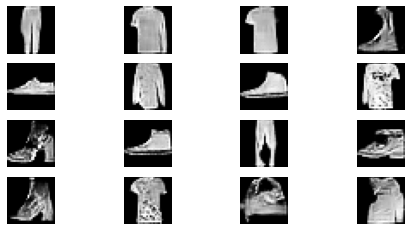

 64%|██████▍   | 32/50 [08:00<04:29, 14.95s/it]

Time for epoch: 32 is 14.740293502807617 seconds
Training started with epoch 33 with 1875 batches...
Epoch: 33: Generator loss:  1.209128, Discriminator loss:  0.976361, Real Score:  0.680274. Fake Score:  0.376316


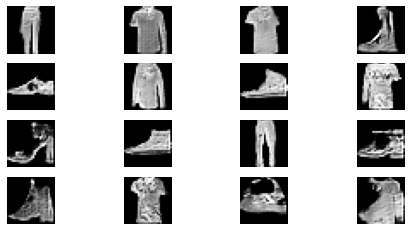

 66%|██████▌   | 33/50 [08:15<04:15, 15.05s/it]

Time for epoch: 33 is 15.302909135818481 seconds
Training started with epoch 34 with 1875 batches...
Epoch: 34: Generator loss:  0.834334, Discriminator loss:  1.371245, Real Score:  0.616003. Fake Score:  0.495254


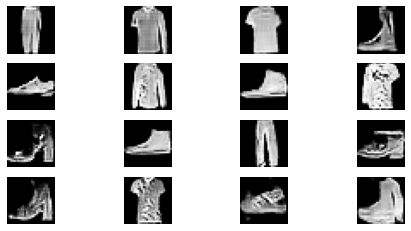

 68%|██████▊   | 34/50 [08:30<03:59, 15.00s/it]

Time for epoch: 34 is 14.867027997970581 seconds
Training started with epoch 35 with 1875 batches...
Epoch: 35: Generator loss:  0.898055, Discriminator loss:  1.316576, Real Score:  0.596477. Fake Score:  0.461938


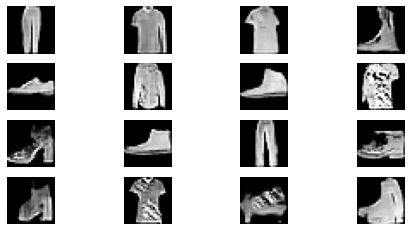

 70%|███████   | 35/50 [08:45<03:44, 14.99s/it]

Time for epoch: 35 is 14.961997747421265 seconds
Training started with epoch 36 with 1875 batches...
Epoch: 36: Generator loss:  0.812911, Discriminator loss:  1.196430, Real Score:  0.689929. Fake Score:  0.485468


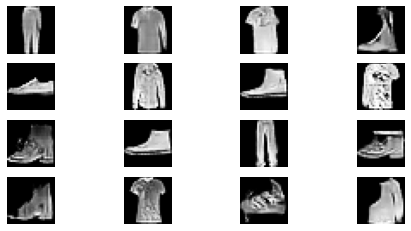

 72%|███████▏  | 36/50 [09:00<03:29, 15.00s/it]

Time for epoch: 36 is 15.023863315582275 seconds
Training started with epoch 37 with 1875 batches...
Epoch: 37: Generator loss:  1.670356, Discriminator loss:  1.150781, Real Score:  0.485960. Fake Score:  0.240180


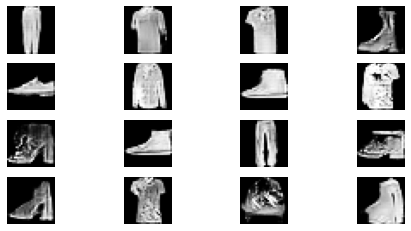

 74%|███████▍  | 37/50 [09:15<03:15, 15.06s/it]

Time for epoch: 37 is 15.196697473526001 seconds
Training started with epoch 38 with 1875 batches...
Epoch: 38: Generator loss:  1.394358, Discriminator loss:  1.018790, Real Score:  0.593524. Fake Score:  0.307932


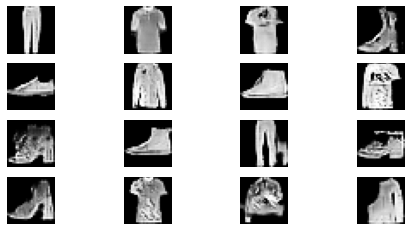

 76%|███████▌  | 38/50 [09:30<03:00, 15.03s/it]

Time for epoch: 38 is 14.94574785232544 seconds
Training started with epoch 39 with 1875 batches...
Epoch: 39: Generator loss:  0.897027, Discriminator loss:  1.279731, Real Score:  0.644364. Fake Score:  0.475734


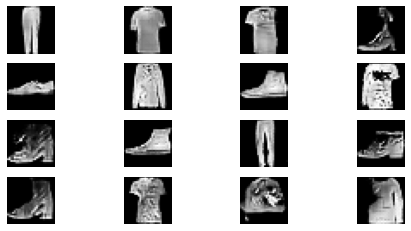

 78%|███████▊  | 39/50 [09:45<02:44, 14.97s/it]

Time for epoch: 39 is 14.83842945098877 seconds
Training started with epoch 40 with 1875 batches...
Epoch: 40: Generator loss:  1.323824, Discriminator loss:  0.937093, Real Score:  0.638322. Fake Score:  0.313482


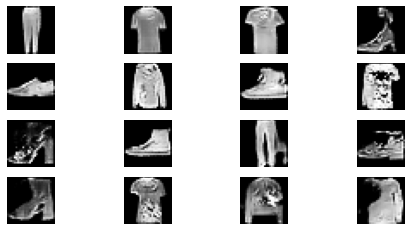

 80%|████████  | 40/50 [10:01<02:30, 15.08s/it]

Time for epoch: 40 is 15.340747833251953 seconds
Training started with epoch 41 with 1875 batches...
Epoch: 41: Generator loss:  0.860494, Discriminator loss:  1.628700, Real Score:  0.472522. Fake Score:  0.473502


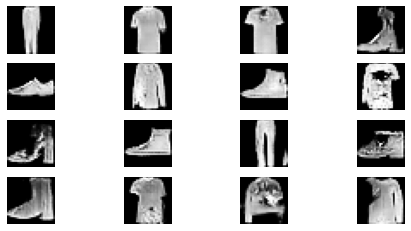

 82%|████████▏ | 41/50 [10:15<02:14, 15.00s/it]

Time for epoch: 41 is 14.79747200012207 seconds
Training started with epoch 42 with 1875 batches...
Epoch: 42: Generator loss:  1.442960, Discriminator loss:  1.382137, Real Score:  0.433441. Fake Score:  0.281129


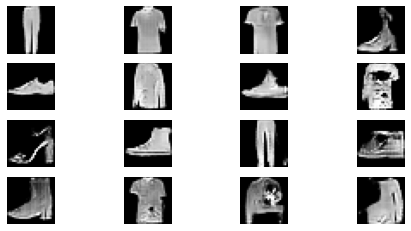

 84%|████████▍ | 42/50 [10:30<02:00, 15.01s/it]

Time for epoch: 42 is 15.054060935974121 seconds
Training started with epoch 43 with 1875 batches...
Epoch: 43: Generator loss:  1.298724, Discriminator loss:  1.519203, Real Score:  0.380954. Fake Score:  0.316915


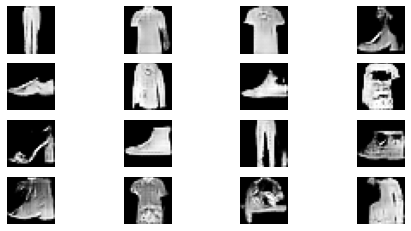

 86%|████████▌ | 43/50 [10:45<01:44, 14.93s/it]

Time for epoch: 43 is 14.739374876022339 seconds
Training started with epoch 44 with 1875 batches...
Epoch: 44: Generator loss:  1.079568, Discriminator loss:  1.080450, Real Score:  0.617292. Fake Score:  0.390997


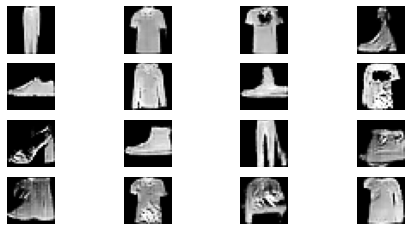

 88%|████████▊ | 44/50 [11:01<01:30, 15.13s/it]

Time for epoch: 44 is 15.592119216918945 seconds
Training started with epoch 45 with 1875 batches...
Epoch: 45: Generator loss:  1.050233, Discriminator loss:  1.094119, Real Score:  0.628929. Fake Score:  0.401642


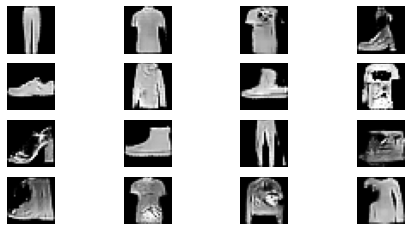

 90%|█████████ | 45/50 [11:16<01:15, 15.05s/it]

Time for epoch: 45 is 14.86950135231018 seconds
Training started with epoch 46 with 1875 batches...
Epoch: 46: Generator loss:  0.987493, Discriminator loss:  1.232513, Real Score:  0.565138. Fake Score:  0.414590


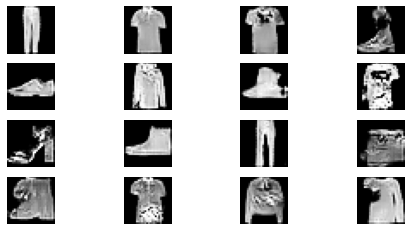

 92%|█████████▏| 46/50 [11:30<00:59, 14.99s/it]

Time for epoch: 46 is 14.846193075180054 seconds
Training started with epoch 47 with 1875 batches...
Epoch: 47: Generator loss:  0.933918, Discriminator loss:  1.242681, Real Score:  0.614205. Fake Score:  0.448325


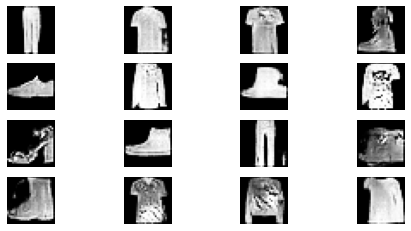

 94%|█████████▍| 47/50 [11:52<00:50, 16.86s/it]

Time for epoch: 47 is 21.23007035255432 seconds
Training started with epoch 48 with 1875 batches...
Epoch: 48: Generator loss:  0.807987, Discriminator loss:  1.158534, Real Score:  0.655165. Fake Score:  0.473888


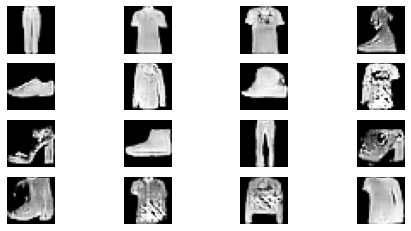

 96%|█████████▌| 48/50 [12:07<00:32, 16.43s/it]

Time for epoch: 48 is 15.406418800354004 seconds
Training started with epoch 49 with 1875 batches...
Epoch: 49: Generator loss:  1.482059, Discriminator loss:  1.259346, Real Score:  0.456407. Fake Score:  0.268933


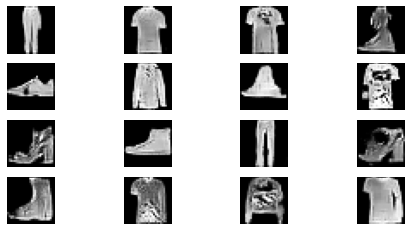

 98%|█████████▊| 49/50 [12:22<00:15, 15.97s/it]

Time for epoch: 49 is 14.895800352096558 seconds
Training started with epoch 50 with 1875 batches...
Epoch: 50: Generator loss:  1.172204, Discriminator loss:  1.399031, Real Score:  0.461403. Fake Score:  0.373123


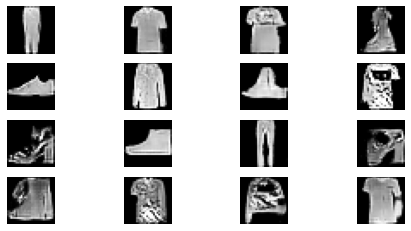

100%|██████████| 50/50 [12:37<00:00, 15.15s/it]

Time for epoch: 50 is 15.026455640792847 seconds


In [44]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

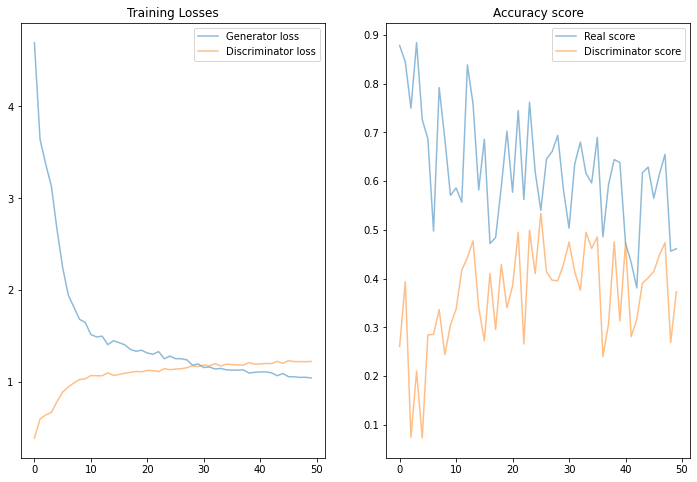

In [45]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(gen_loss_epochs, label="Generator loss", alpha=0.5)
ax1.plot(disc_loss_epochs, label="Discriminator loss", alpha=0.5)
ax1.legend()

ax1.set_title("Training Losses")
ax2.plot(real_score_list, label="Real score", alpha=0.5)
ax2.plot(fake_score_list, label="Discriminator score", alpha=0.5)
ax2.set_title("Accuracy score")

ax2.legend()

